In [2]:
import tensorflow as tf
import numpy as np
import tarfile, os
from PIL import ImageDraw
from PIL import Image
from six.moves import urllib
from matplotlib import pyplot as plt
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import cv2 as cv
print tf.__version__
%matplotlib inline

1.14.0-rc1


In [3]:
# What model to download.
# Models can bee found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [4]:
# Download model
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

# Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')   

In [5]:
# Number of classes to detect
NUM_CLASSES = 90
# Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [6]:
# Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

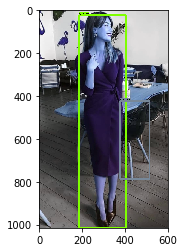

In [7]:
image_url = 'sample2.jpg'
image, boxes, scores = [], [], []
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        global image_np, boxes, scores
        image_np = cv.imread(image_url)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Extract image tensor
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Extract detection boxes
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Extract detection scores
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        # Extract detection classes
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        # Extract number of detectionsd
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)
        # Display output
        plt.figure()
        plt.imshow(image_np)
        plt.show()
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)

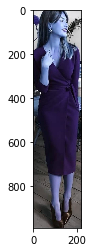

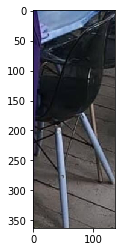

In [22]:
score_thresh = .5
height, width, rgb = image_np.shape
objects = []
for box in boxes[scores > score_thresh]:
    image_ = cv.imread(image_url)
    image_pil = Image.fromarray(np.uint8(image_)).convert('RGB')
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * width, xmax * width,
                                  ymin * height, ymax * height)
    
    image_pil = image_pil.crop((left, top, right, bottom))
    image_pil.show()
    objects.append(np.array(image_pil))
    plt.imshow(image_pil)
    plt.show()
objects = np.array(objects)      

In [63]:
IMAGE_DIM = (380, 380, 3)
SHIFT = 30

def get_cropped_image(x0, y0, x1, y1, image):
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    image_pil = image_pil.crop((x0, y0, x1, y1))
    image = np.array(image_pil)
    
    margin_x = max(0, IMAGE_DIM[0] - x1)
    margin_y = max(0, IMAGE_DIM[1] - y1)
    if margin_x != 0:
        print np.full((margin_x, 380, 3), 255).shape
        print image.shape
        image = np.concatenate((image, np.full((380, margin_x, 3), 255)), axis=1)
    if margin_y !=0:
        image = np.concatenate((image, np.full((margin_y, 380, 3), 255)), axis=0)
    plt.imshow(image)
    plt.show()
    
def subset_image(image, horizontal=True, start_x=0, start_y=0):
    height, width, rgb = image.shape
    hor_mult = horizontal if 1 else 0
    ver_mult = horizontal if 0 else 1
    x0, y0 = start_x, start_y
    while True:
        x1, y1 = x0+IMAGE_DIM[0], y0+IMAGE_DIM[1] 
        if horizontal and x1 > width:
            subset_image(image, horizontal=(not horizontal), start_x=x0, start_y=y0)
            break
        elif not horizontal and y1 > height:
            break
        get_cropped_image(x0, y0, x1, y1, image)
        
        subset_image(image, horizontal=(not horizontal), start_x=x0, start_y=y0)
        x0, y0 = x1+SHIFT*hor_mult, y1+SHIFT*ver_mult

        
for obj in objects:
    subset_image(obj)
#     subset_image(obj, horizontal=False)
    break